# Fraud detection with machine learning

<br>
<br>

We are going to analyze the fraud detection bank dataset (https://www.kaggle.com/code/dcw8161/fraud-detection-bank-dataset/data), and see if we can make a model that can reliably detect fraud. We start be importing the data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

df = pd.read_csv("fraud_detection_bank_dataset.csv")


print(df.head())

   Unnamed: 0  col_0  col_1  col_2  col_3  col_4  col_5  col_6  col_7  col_8  \
0           0      9   1354      0     18      0      1      7      9      0   
1           1      0    239      0      1      0      1      0      0      0   
2           2      0    260      0      4      0      3      6      0      0   
3           3     17    682      0      1      0      0      8     17      0   
4           4      1    540      0      2      0      1      7      1      0   

   ...  col_103  col_104  col_105  col_106  col_107  col_108  col_109  \
0  ...        0        0        0        1        1        0        0   
1  ...        0        1        0        0        0        0        0   
2  ...        0        0        0        1        1        0        0   
3  ...        0        1        0        1        1        0        0   
4  ...        0        0        0        1        1        0        0   

   col_110  col_111  targets  
0        0       49        1  
1        0       5

It is a bit unfortunate that we actually don't know what values the columns represent, as this is not explicitly explained by the columns or on Kaggle. But we soldier on.
<br>
<br>
We want to drop the feature called Unnamed: 0 because it just counts the numer of rows. The rows are also arranged such that the $n$ first rows (let's say the total number of rows are $m$) are targets with value $v_i = 1,\;\;\; i\leq n$, and the remaining values are $v_i=0, \;\;\; n<i\leq m$. This makes it so that the first column can perfectly predict the targets. I will demonstrate this, but first let's seperate the targets from the main table

In [2]:
targets = df["targets"]
first_column = df["Unnamed: 0"]
df.drop("targets", inplace = True, axis = 1)
df.drop('Unnamed: 0', inplace = True, axis = 1)
X = pd.DataFrame.to_numpy(df)
Y = np.asarray([val for val in targets])

5438


Text(0, 0.5, 'target')

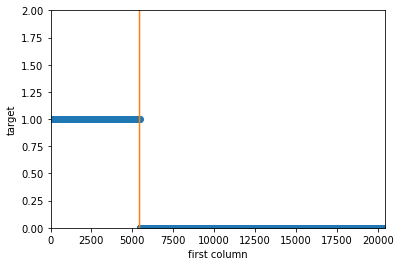

In [3]:
dividing_line = np.zeros(len(targets))
index = 0

for element in targets:
    if element != 1:
        print(index)
        dividing_line[:] = index
        break
    else:
        index += 1
        
plt.plot(first_column, targets, "o")
plt.plot(dividing_line, first_column)
plt.axis([0,len(targets),0,2])
plt.xlabel("first column")
plt.ylabel("target")

As we see, we now have a classification model with $100\%$ accuracy, that can be perfectly described by the following function
$$
y(x)=
    \begin{cases}
        1, &  0<x<5438\\
        0, &  5438\leq x \leq \text{len}(\text{targets})  
    \end{cases}
\
$$

This is obviously just silly, and is purely an artifact of how the data is structured. This is why we delete the column  "Unnamed: 0"

We now have a feature matrix $X$ with 112 columns. It might be a good idea to check whether we need all of these columns, or if we can get away with using fewer. We do this with principal component analysis (PCA)

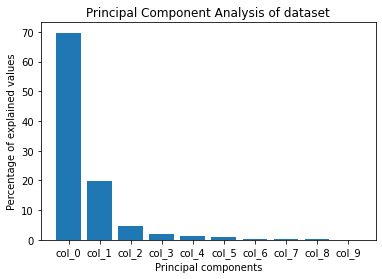

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


scaler = StandardScaler()
X_scaled = scaler.fit(X.T).transform(X.T)
#Doing PCA
pca = PCA()
pca.fit(X_scaled.T)
pca_data = pca.transform(X_scaled.T)
#Rounding off the percentages
per_val = np.round(pca.explained_variance_ratio_*100, decimals = 1)
#Labels of PC for plotting
labels = df.keys()
labels2 = np.arange(1,len(labels)+1)



#We plot the 10 highest contributors
plt.bar(x=range(1,11), height = per_val[0:10], tick_label = labels[0:10])
plt.title("Principal Component Analysis of dataset")
plt.ylabel("Percentage of explained values")
plt.xlabel("Principal components")
plt.show()

We can see that most of the variance comes from the 8 first columns. We can try to reduce the dataset to the 8 first columns, and see if there is a training time/ accuracy trade-off here

In [5]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from time import perf_counter

#Create a dataset with only the 9 highest contributors
X_reduced = X[:,0:8]


X_train, X_test, X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X, X_reduced, Y, test_size = 0.2)



t_train_start = perf_counter()

model_full = AdaBoostClassifier()
model_full.fit(X_train, y_train)
predicted_full = model_full.predict(X_test)

t_train_stop = perf_counter()
t_total_full = t_train_stop-t_train_start

t_train_start = perf_counter()

model_reduced = AdaBoostClassifier()
model_reduced.fit(X_train_reduced, y_train)
predicted_reduced = model_reduced.predict(X_test_reduced)

t_train_stop = perf_counter()
t_total_reduced = t_train_stop-t_train_start

S_f = accuracy_score(predicted_full, y_test)

S_r = accuracy_score(predicted_reduced, y_test)

print("Time to train on full dataset: %1.2f s" %(t_total_full))
print("Time to train on reduced dataset: %1.2f s" %(t_total_reduced))
print("Training accuracy on full dataset: %1.2f" %(S_f))
print("Training accuracy on reduced dataset: %1.2f" %(S_r))

Time to train on full dataset: 1.79 s
Time to train on reduced dataset: 0.46 s
Training accuracy on full dataset: 0.91
Training accuracy on reduced dataset: 0.85


 We can see that we save a significant amount of time, although we do sacrifice a lot of accuracy. We move along with the reduced dataset, and see if we can make some decent predictions. The reason for this is that we can save a whole lot of time in training, if we can find a good enough model.
 <br>
 We start with cross validation

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
clf = AdaBoostClassifier()
#shuffle(X_train_reduced, y_train)
scores = cross_val_score(clf, X_train_reduced, y_train, cv = 5, scoring = "accuracy")
scores

array([0.86381679, 0.85312977, 0.83847328, 0.85129771, 0.85247404])

That did not really improve anything. We can also do an (not really) exhaustive grid search, but before that we can check if the learning rate is of the correct order of magnitude. This is a largely useless excersise (in this case), but let's do it anyway

In [7]:
#Use logspace when checking order of magnitude
a = np.logspace(-10, 1, 100)
accs2 = np.zeros(len(a))

i = 0
for lr in a:
    model_reduced = AdaBoostClassifier(n_estimators = 40, learning_rate = lr)
    model_reduced.fit(X_train_reduced, y_train)
    pred_ada = model_reduced.predict(X_test_reduced)
    accs2[i] = accuracy_score(pred_ada, y_test)
    i += 1

1.0


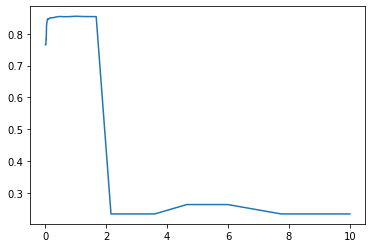

In [8]:
plt.plot(a, accs2)
print(a[np.argmax(accs2)])


We see that a  sensible learning rate $\gamma$ will roughly be on the interval $\gamma \in [0.1, 1.9]$, so we use that. The number of estimators we let be between 1 and 50 

In [9]:
learning_rates = np.linspace(0.1, 2, 10)
estimators = np.arange(1,50, 5)

accs = np.zeros((len(estimators), len(learning_rates)))

i = 0
for est in estimators:
    j = 0
    for lr in learning_rates:
        model_reduced = AdaBoostClassifier(n_estimators = est, learning_rate = lr)
        model_reduced.fit(X_train_reduced, y_train)
        pred_ada_2 = model_reduced.predict(X_test_reduced)
        accs[i, j] = accuracy_score(pred_ada_2, y_test)
        j += 1
    i += 1


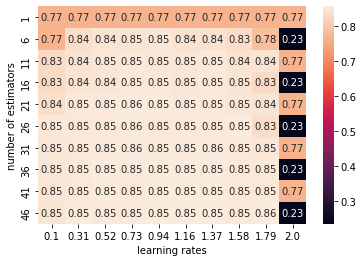

In [10]:
import seaborn as sb

s = sb.heatmap(accs, annot = True, xticklabels = np.round(learning_rates, decimals = 2), yticklabels = estimators)
s.set(xlabel = "learning rates", ylabel = "number of estimators")

pred2 = model_reduced.predict(X_train_reduced)
acc2 = accuracy_score(pred2, y_train)

A more exhaustive search proved to be unfruitful. We might have to try other methods if we want to achieve a higher accuracy. 

In [11]:
boost = GradientBoostingClassifier()
boost.fit(X_train_reduced, y_train)
pred_boost = boost.predict(X_test_reduced)
acc_boost = accuracy_score(pred_boost, y_test)


In [12]:
print(acc_boost)

0.8600390815828041


Without tweaking any parameters, we get a model equal to that of the AdaBoost. We might be able to improve the gradient boosted model with some parameter tuning, but I'm not going to do that.

We have seen that the Adaboost method is not (in this case) particularly sensitive to learning rate and number of estimators, so it probably won't help us greatly trying to adjust these hyper-parameters. We could take a look at the base_estimator parameter (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), and create a custom decision tree, but it probably won't increase accuracy significantly. Let me demonstrate

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_halving_search_cv

base = DecisionTreeClassifier(max_depth = 6)

model_deep = AdaBoostClassifier(base_estimator = base, n_estimators = 50, learning_rate = 1)
model_deep.fit(X_train_reduced, y_train)
pred_ada_base = model_deep.predict(X_test_reduced)

accuracy_score(pred_ada_base,y_test)

0.8326819736199316

Still no improvement. We could try using cross-validation, grid-search, or another method of parameter tuning, bit I think it's time we changed pace. Let's see if a basic neural network can help us crank that accuracy (and Soulja Boy)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

#For one-hot encoding the targets
def to_categorical_numpy(integer_vector):
    n_inputs = len(integer_vector)
    n_categories = np.max(integer_vector) + 1
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs), integer_vector] = 1

    return onehot_vector

After some testing and tuning, I found the following architecture, optimizer, loss function, etc, to be working good (not optimal, but better than everything else i tried)

In [22]:
y_onehot = to_categorical_numpy(Y)
X_train, X_test, y_train_onehot, y_test_onehot, y_train, y_test = train_test_split(X_reduced, y_onehot, Y, test_size = 0.2 )

in_size = len(X_train[0])
out_size = len(y_train_onehot[0])

model = Sequential()
model.add(Dense(units = 512, activation = "sigmoid", input_dim = in_size))
model.add(Dense(units = out_size, activation = "softmax"))
model.compile(loss = "BinaryCrossentropy", optimizer = "Adamax", metrics = "accuracy")

#KLDivergence
#LogCosh

model.fit(X_train, y_train_onehot, epochs = 100, batch_size = 128)




Epoch 1/100
128/128 [==============================] - 1s 2ms/step - loss: 0.5302 - accuracy: 0.7352
Epoch 2/100
128/128 [==============================] - 0s 2ms/step - loss: 0.4806 - accuracy: 0.7784
Epoch 3/100
128/128 [==============================] - 0s 2ms/step - loss: 0.4429 - accuracy: 0.8117
Epoch 4/100
128/128 [==============================] - 0s 2ms/step - loss: 0.4223 - accuracy: 0.8234
Epoch 5/100
128/128 [==============================] - 0s 2ms/step - loss: 0.4123 - accuracy: 0.8286
Epoch 6/100
128/128 [==============================] - 0s 2ms/step - loss: 0.4060 - accuracy: 0.8309
Epoch 7/100
128/128 [==============================] - 0s 2ms/step - loss: 0.4030 - accuracy: 0.8320
Epoch 8/100
128/128 [==============================] - 0s 2ms/step - loss: 0.4011 - accuracy: 0.8325
Epoch 9/100
128/128 [==============================] - 0s 2ms/step - loss: 0.3983 - accuracy: 0.8347
Epoch 10/100
128/128 [==============================] - 0s 2ms/step - loss: 0.3969 - accura

In [17]:
pred_nn = model.predict(X_test_reduced)
s = 0
for i in range(len(X_test)):
    true = np.argmax(y_test_onehot[i])
    guess = np.argmax(pred_nn[i])
    if true == guess:
        s += 1
print("test accuracy is " + str(s/len(y_test)))


test accuracy is 0.853199804592086


Still no improvement. Now let's try the neural net again with the full dataset, just because thus far the models we have made have been a bit sad

In [23]:
X_train, X_test, y_train_onehot, y_test_onehot, y_train, y_test = train_test_split(X, y_onehot, Y, test_size = 0.2 )

in_size = len(X_train[0])
out_size = len(y_train_onehot[0])

model = Sequential()
model.add(Dense(units = 512, activation = "sigmoid", input_dim = in_size))
model.add(Dense(units = out_size, activation = "softmax"))
model.compile(loss = "BinaryCrossentropy", optimizer = "Adamax", metrics = "accuracy")

#KLDivergence
#LogCosh

model.fit(X_train, y_train_onehot, epochs = 100, batch_size = 128)

Epoch 1/100
128/128 [==============================] - 1s 2ms/step - loss: 0.4220 - accuracy: 0.8211
Epoch 2/100
128/128 [==============================] - 0s 2ms/step - loss: 0.3686 - accuracy: 0.8483
Epoch 3/100
128/128 [==============================] - 0s 2ms/step - loss: 0.3364 - accuracy: 0.8757
Epoch 4/100
128/128 [==============================] - 0s 2ms/step - loss: 0.3148 - accuracy: 0.8868
Epoch 5/100
128/128 [==============================] - 0s 2ms/step - loss: 0.3002 - accuracy: 0.8902
Epoch 6/100
128/128 [==============================] - 0s 2ms/step - loss: 0.2888 - accuracy: 0.8948
Epoch 7/100
128/128 [==============================] - 0s 2ms/step - loss: 0.2807 - accuracy: 0.8969
Epoch 8/100
128/128 [==============================] - 0s 2ms/step - loss: 0.2738 - accuracy: 0.8999
Epoch 9/100
128/128 [==============================] - 0s 2ms/step - loss: 0.2689 - accuracy: 0.9017
Epoch 10/100
128/128 [==============================] - 0s 2ms/step - loss: 0.2649 - accura

We're now back at an accuracy comparable to that of the first adaboost model. Let's take a look at the confusion matrix:

4094


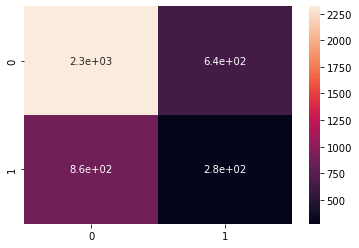

In [25]:
pred_new = np.zeros(len(pred_nn))
i = 0
for val in pred_nn:
    pred_new[i] = np.argmax(pred_nn[i])
    i += 1

cm = confusion_matrix(y_test, pred_new)
sb.heatmap(cm, annot = True)
print(np.sum(cm))

We see that our model would have to be significantly improved if we want to actually use it. If it were to be used as an assist tool it could be ok, but as an automated fraud detector/ preventor it will cause many people a lot of grief. 
<br>
<br>
As I've mentioned before, we don't know what each column in the dataset represent. But let's for a moment assume that they represent some information about bank transactions. If this is the case, a relatively large number ($\sim 3.3\%$) of false positives won't be a problem, because if a costumer gets flagged with having multiple predicted fraudulent transactions the probability of these being false is greatly reduced. Unless the machine learning model has falsly correlated some attributes as being predictors, and this costumer over-represent these attributes. A costumer with one positive out of many negatives may warrant investigation but one could perhaps assume the positive to be false. 
<br>
<br>
The false negatives are trickier as they won't be flagged at all, and will go on undetected. Unless someone with a high number of true positives also get a few negative predictions (false in this case), it's hard to do anything them at all.  
<br>
<br>
To make a good model we will have to up the accuracy to at least $98-99\%$. To do this, more data would be great. The more rows of data we have, the more probable it becomes that our model will achieve the desired accuracy. There is also a lot more that could be done in the model selection department. Building and tuning a neural network is a dark art and this notebook is just a demo of a few ML techniques and such. 
<br>
